In [375]:
import pandas as pd
import datetime
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
import seaborn as sns

import warnings                               
warnings.filterwarnings('ignore')

In [376]:
df = pd.read_csv('../train.csv')
df[:10]

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363
5,2018-01-01 12:10:00+00:00,103.805858,29.177815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,20.305917,NaN,NaN,274.00,3.781696
6,2018-01-01 12:20:00+00:00,89.304200,28.871782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.00,18.093654,NaN,NaN,265.00,3.727462
7,2018-01-01 12:30:00+00:00,136.319172,28.531796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,27.029096,NaN,NaN,255.00,4.154484
8,2018-01-01 12:40:00+00:00,217.112015,28.344782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.00,43.690222,NaN,NaN,249.00,4.642134
9,2018-01-01 12:50:00+00:00,256.428119,28.244747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.00,51.545672,NaN,NaN,241.00,4.841759


In [377]:
df.shape, df.isna().sum()

((77202, 20),
 Datetime                            0
 ActivePower                         0
 AmbientTemperatue                 896
 BearingShaftTemperature         26684
 Blade1PitchAngle                43282
 Blade2PitchAngle                43365
 Blade3PitchAngle                43365
 GearboxBearingTemperature       26682
 GearboxOilTemperature           26670
 GeneratorRPM                    26674
 GeneratorWinding1Temperature    26656
 GeneratorWinding2Temperature    26649
 HubTemperature                  26792
 MainBoxTemperature              26704
 NacellePosition                 20424
 ReactivePower                      42
 RotorRPM                        26680
 TurbineStatus                   26466
 WindDirection                   20424
 WindSpeed                         308
 dtype: int64)

In [378]:
df = df.fillna(df.drop(columns=['Datetime']).mean())
df.isna().sum()

Datetime                        0
ActivePower                     0
AmbientTemperatue               0
BearingShaftTemperature         0
Blade1PitchAngle                0
Blade2PitchAngle                0
Blade3PitchAngle                0
GearboxBearingTemperature       0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
GeneratorWinding2Temperature    0
HubTemperature                  0
MainBoxTemperature              0
NacellePosition                 0
ReactivePower                   0
RotorRPM                        0
TurbineStatus                   0
WindDirection                   0
WindSpeed                       0
dtype: int64

In [379]:
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.date
df = df.groupby(df['Datetime']).mean()
df.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01,366.223561,25.528849,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,269.243261,74.042120,11.543193,2655.012634,269.243261,5.263797
2018-01-02,462.550740,25.357526,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,263.072199,93.555723,11.543193,2655.012634,263.072199,5.390719
2018-01-03,454.417752,24.379363,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,279.048569,91.627843,11.543193,2655.012634,279.048569,5.295225
2018-01-04,369.952190,24.912347,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,278.106921,74.360621,11.543193,2655.012634,278.106921,5.094994
2018-01-05,319.446595,23.535679,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,286.173749,64.366148,11.543193,2655.012634,286.173749,4.915224


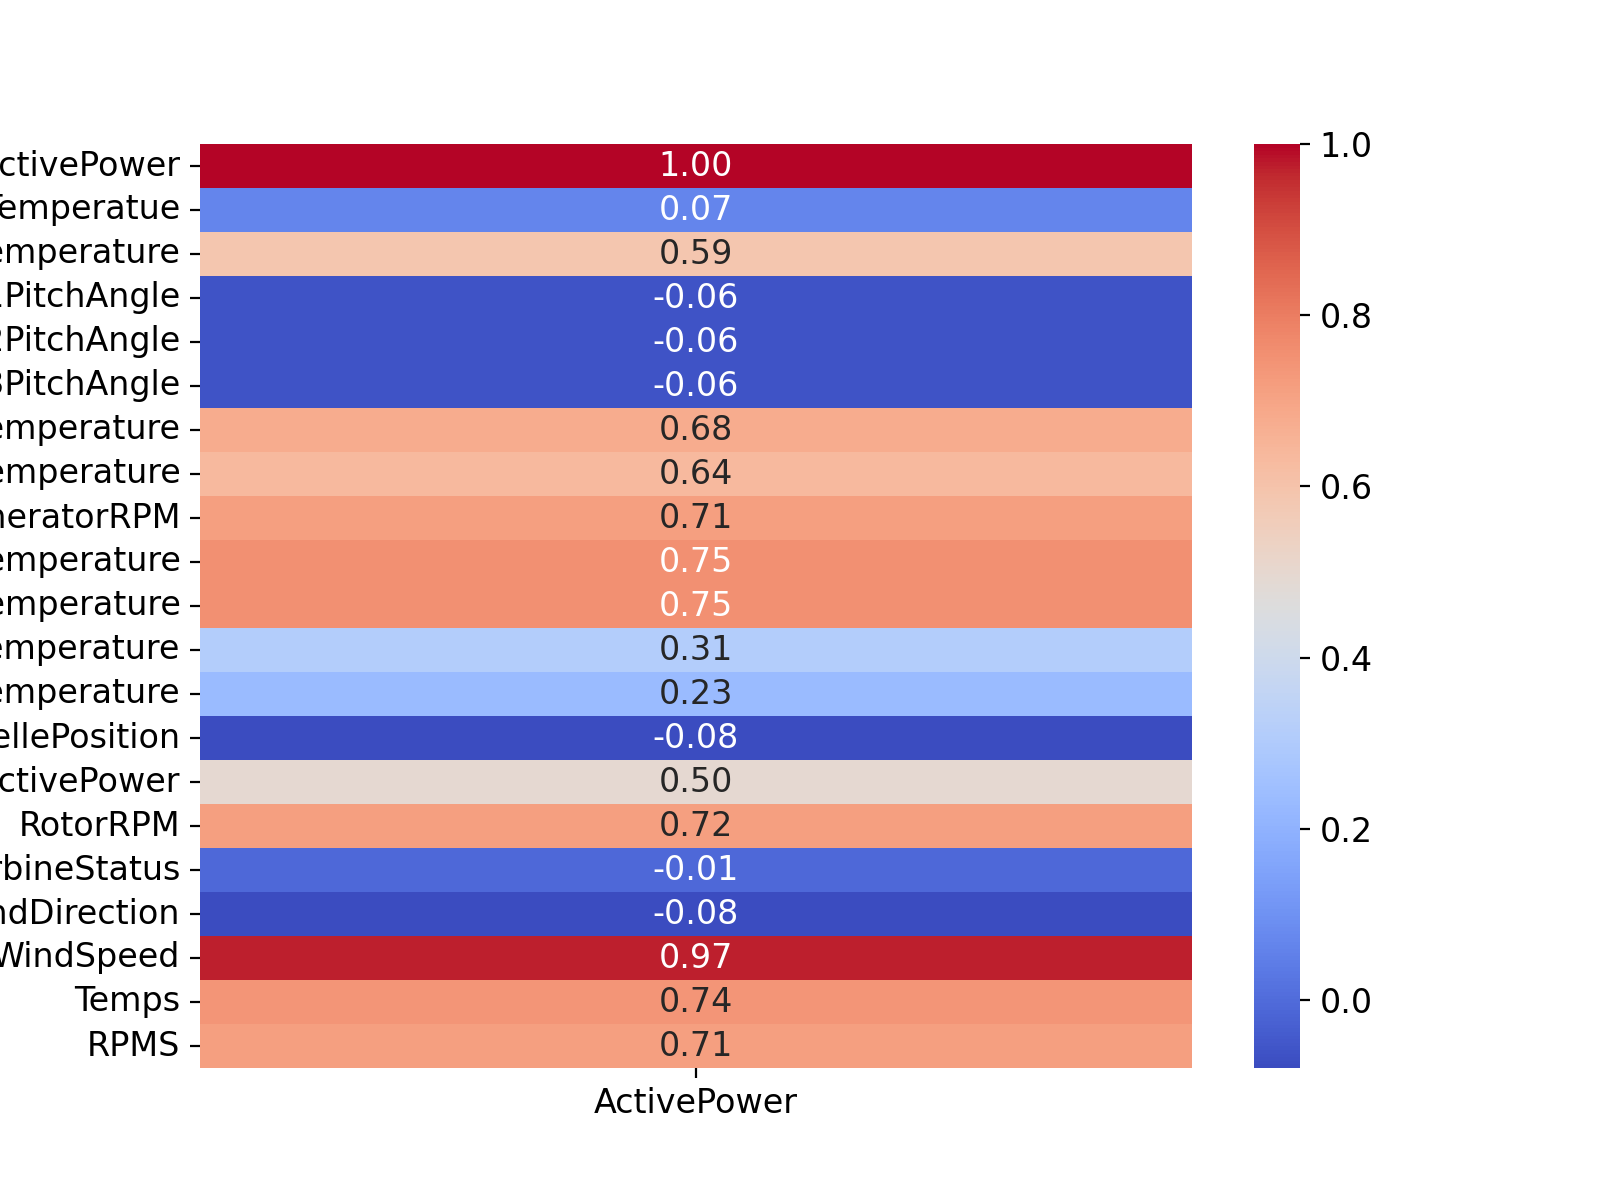

In [394]:

df['Temps'] = (df['GeneratorWinding2Temperature'] + df['GeneratorWinding2Temperature'] + df['GearboxBearingTemperature'] + df['GearboxOilTemperature'])
df['RPMS'] = (df['GeneratorRPM'] + df['RotorRPM'])

corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr[['ActivePower']], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


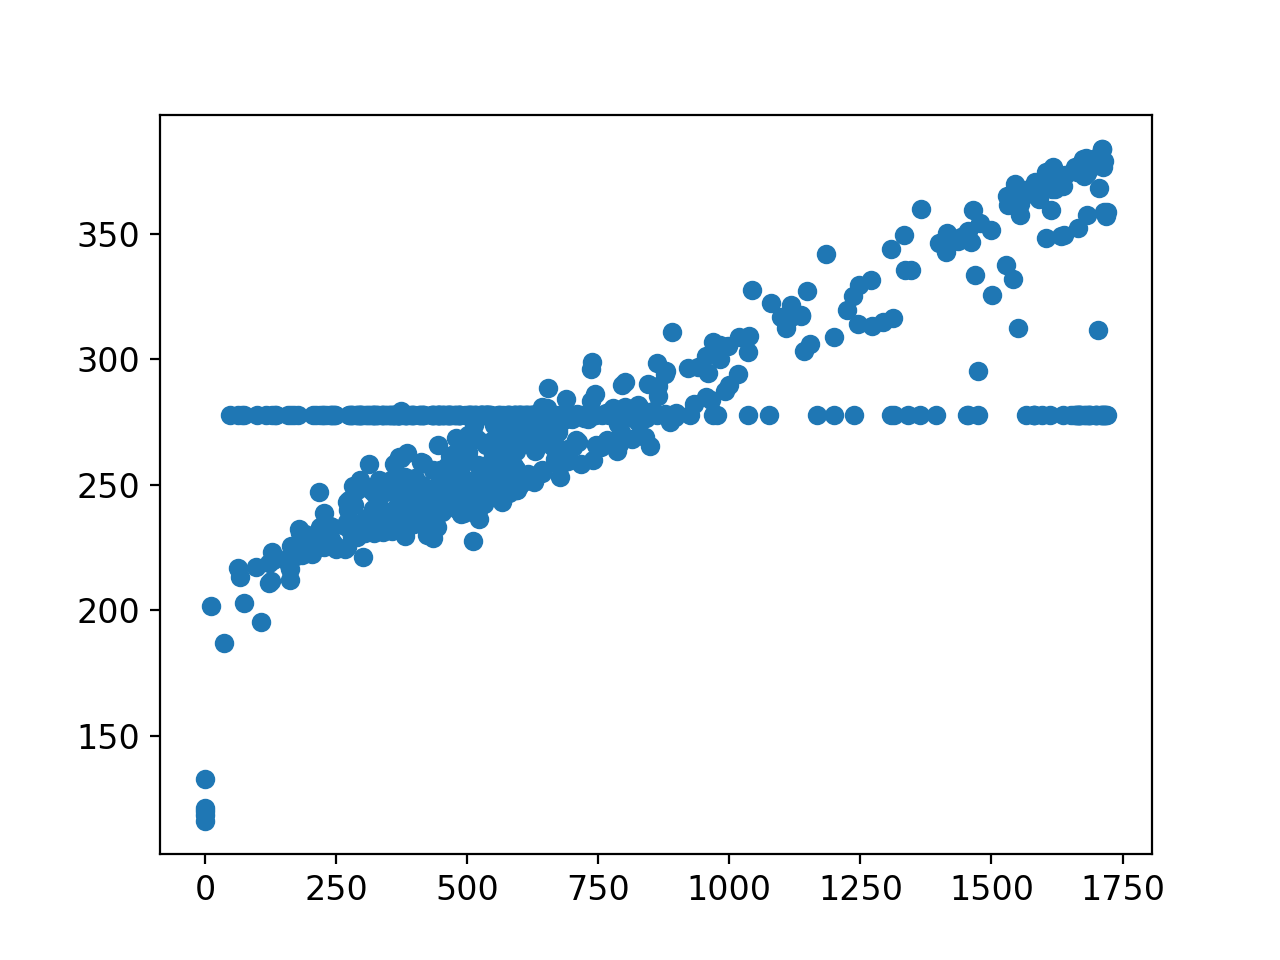

In [395]:
plt.scatter(df['ActivePower'], df['Temps']) #  horizontal line shows the mean impupted values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


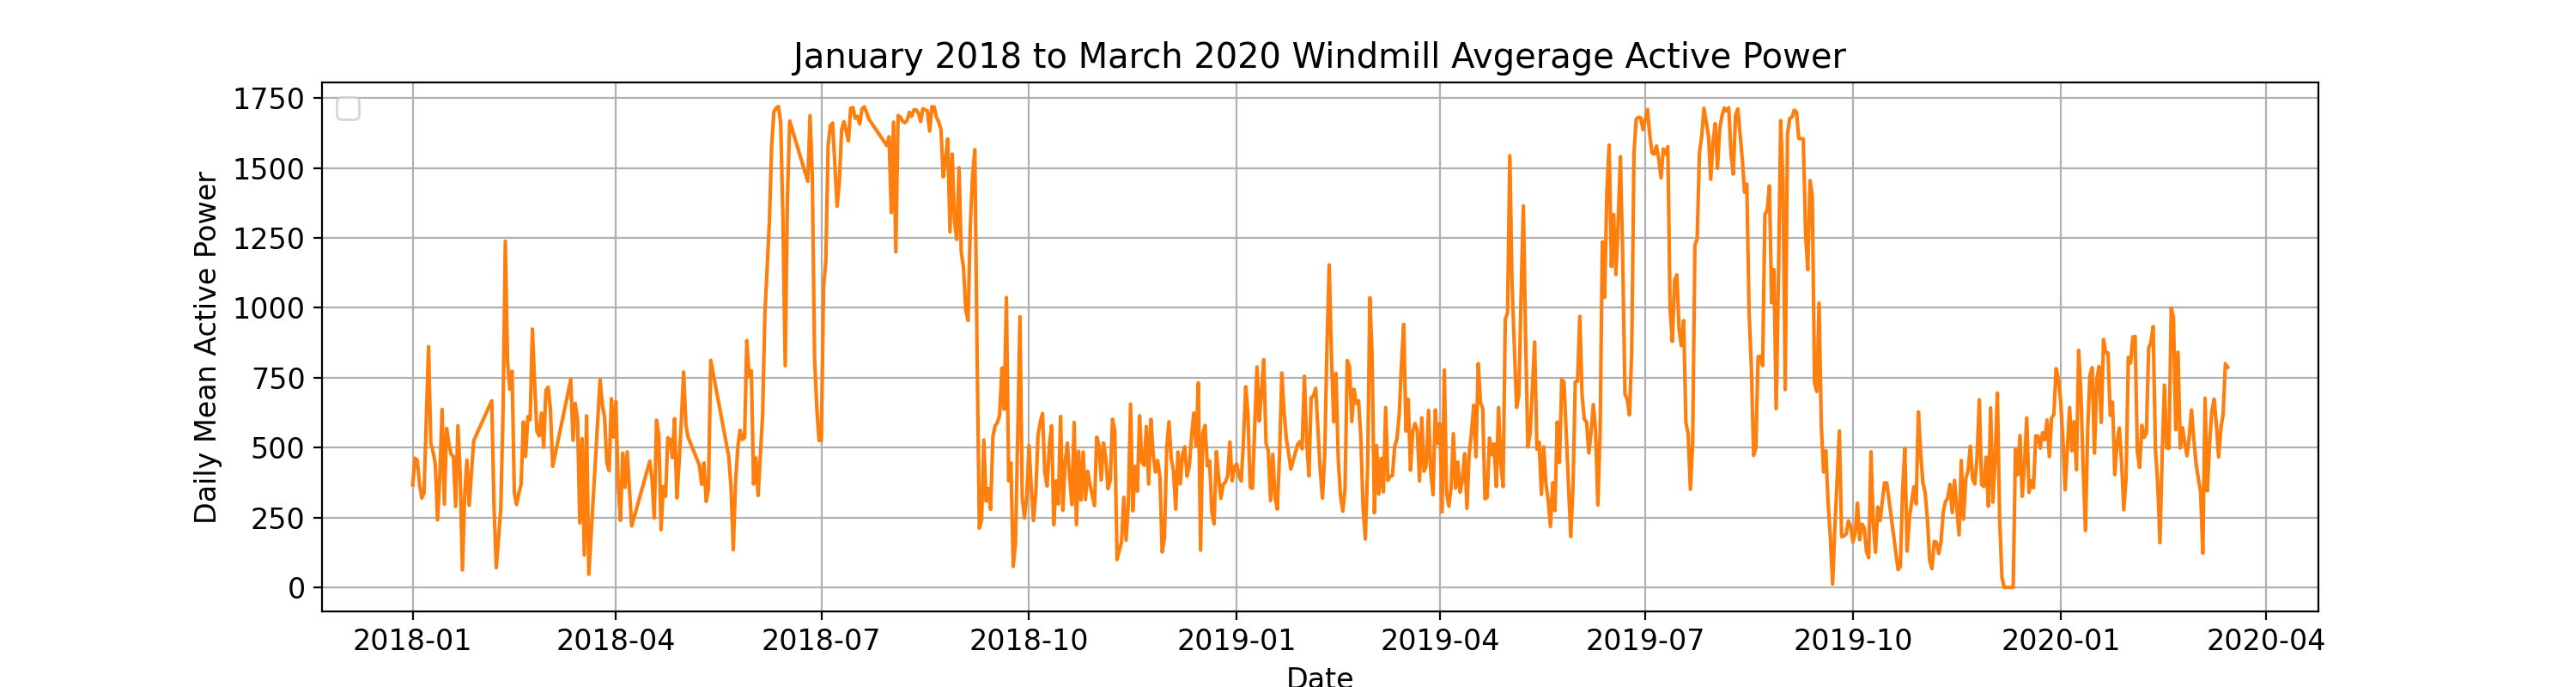

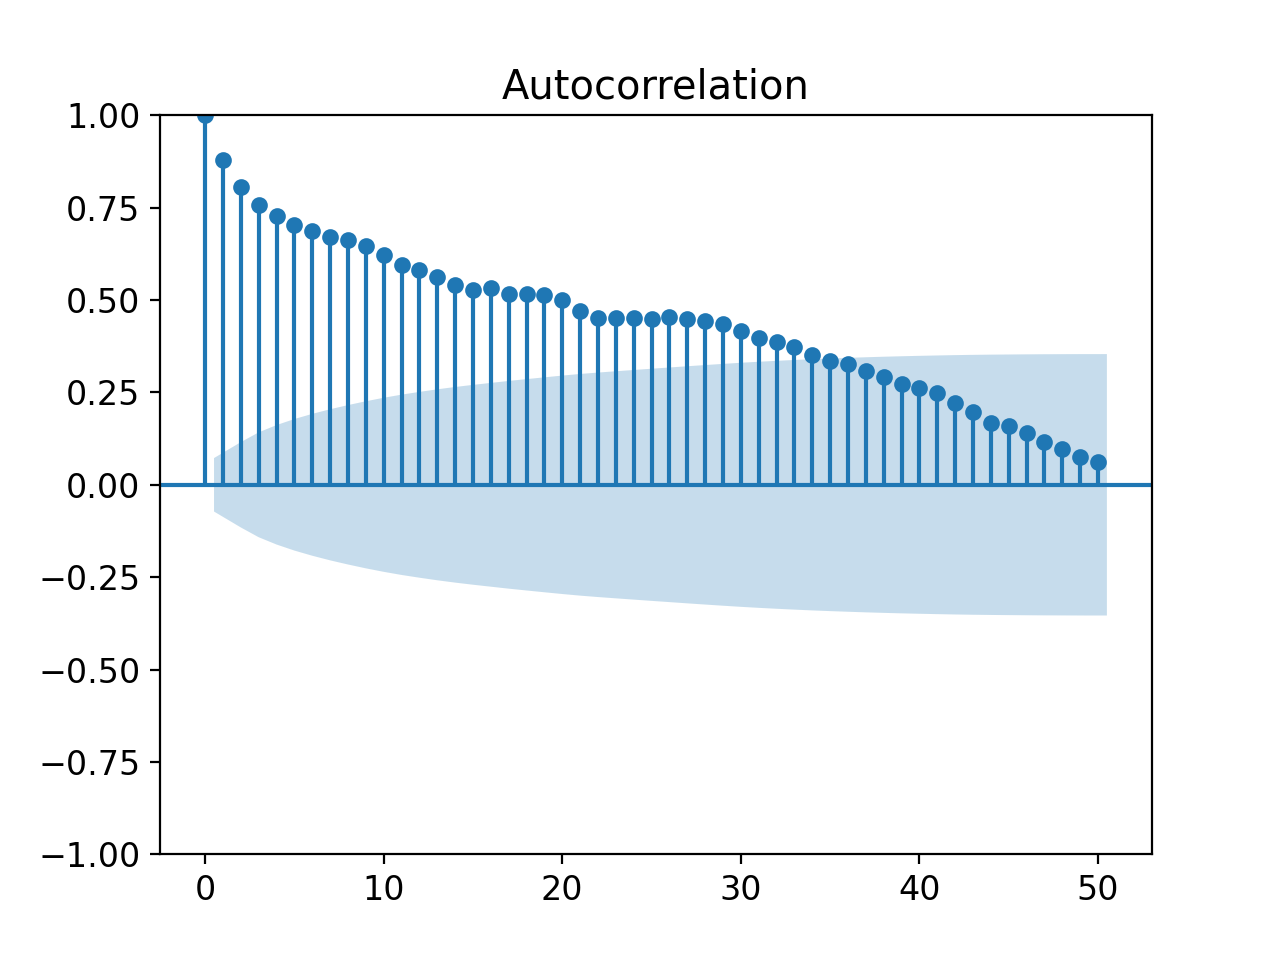

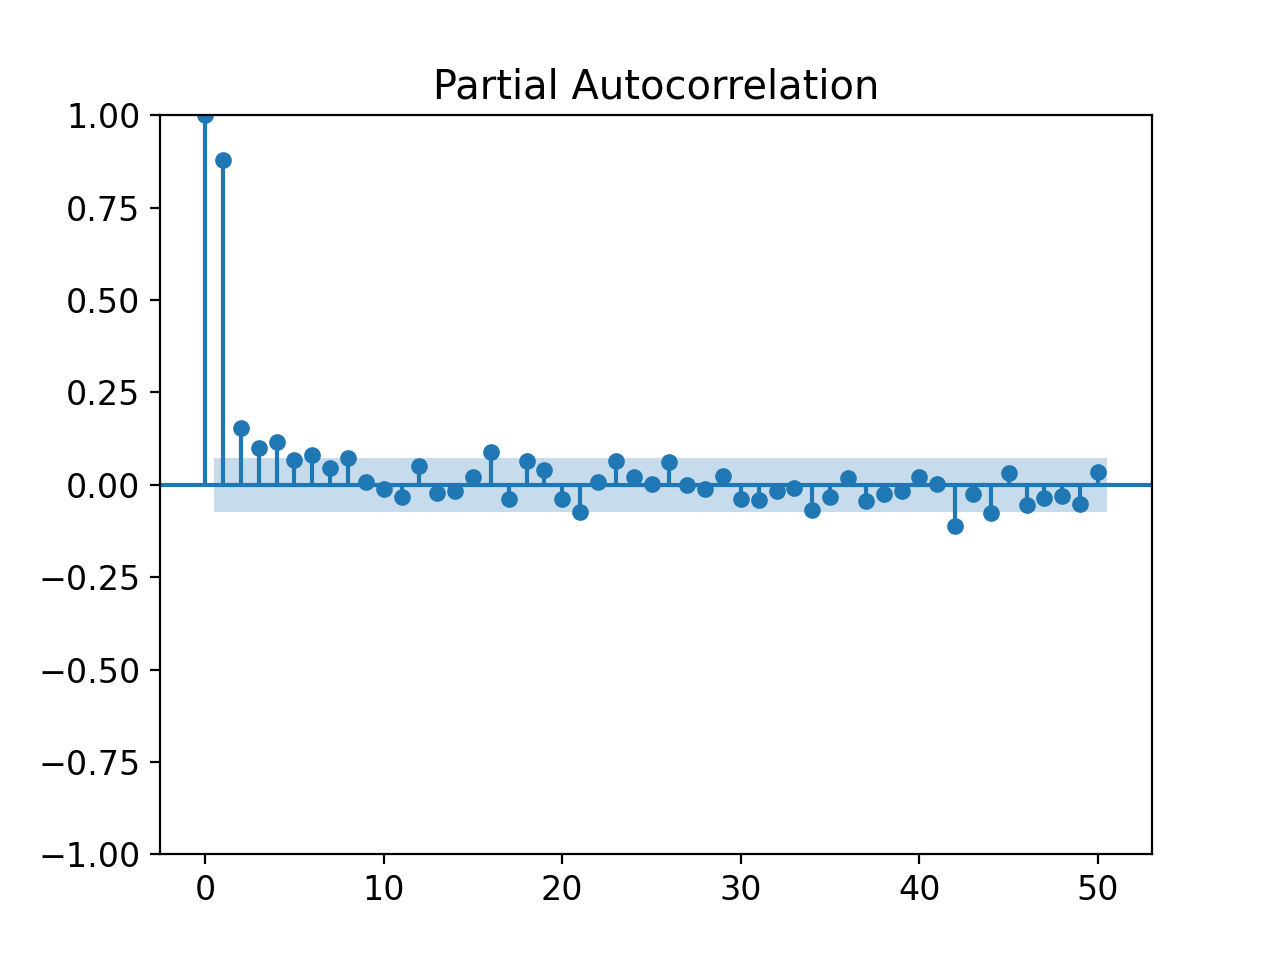


adf test p-value: 0.01792376595212781 ==> stationary


In [396]:
#time series plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(df['ActivePower'], color='tab:orange')#, label='Daily Confirmed Case')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Mean Active Power')
ax.set_title('January 2018 to March 2020 Windmill Avgerage Active Power')
ax.grid(True)
ax.legend(loc='upper left')
plt.show()
# ACF
plot_acf(df['ActivePower'],lags=50)
plt.show()
# PACF
plot_pacf(df['ActivePower'],lags=50)
plt.show()
# Dickey Fuller Test
adf_result = adfuller(df['ActivePower'], autolag="AIC")[1]
if adf_result <= 0.05:
    print(f'\nadf test p-value: {adf_result} ==> stationary')
else:
    print(f'\nadf test p-value: {adf_result} ==> non-stationary')

In [397]:
def evaluate_models_cv_exog(dataset, exog, p_values, d_values, q_values, P_values, D_values, Q_values, m, k):
    K=k
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=4
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(K):
                                train, test = dataset[0:train_size+k*validation_size], dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                train_x, test_x = exog[0:train_size+k*validation_size], exog[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = ARIMA(train, exog=train_x, order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                predictions=model_fit.predict(start=train_size+k*validation_size, end=train_size+(k+1)*validation_size-1, exog=test_x)
                                y_bar = test.mean(numeric_only=True)
                                rmse += np.sum(mean_squared_error(np.array(predictions), test)) / test.shape[0]
                            rmse_avg=rmse/K
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMAX%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMAX%s RMSE=%.3f' % (best_cfg, best_rmse))

In [398]:
p = [5]
d = [0]
q = [5]
P = [5]
D = [0]
Q = [3]
m = 12
k = 3
# 

# evaluate_models_cv_exog(df['ActivePower'], df[['GeneratorRPM', 'WindSpeed']], p, d, q, P, D, Q, m, k) # (0*3)(5,0,3,12) # 711.55

In [399]:
df['AmbientTemperatue']

Datetime
2018-01-01    25.528849
2018-01-02    25.357526
2018-01-03    24.379363
2018-01-04    24.912347
2018-01-05    23.535679
                ...    
2020-03-11    28.276232
2020-03-12    29.094133
2020-03-13    30.088163
2020-03-14    29.395626
2020-03-15    28.176449
Name: AmbientTemperatue, Length: 734, dtype: float64

In [424]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.forecasting.theta import ThetaModel
k = 130
exog = ['Temps', 'WindSpeed', 'RotorRPM']


y = df['ActivePower'][:-k]
X = df[exog][:-k]

testX, testY = df[exog][-k:], df['ActivePower'][-k:]

# Fit a linear regression model
reg_model = LinearRegression()
reg_model.fit(X, y)

# Get the residuals
y_fitted = reg_model.predict(X)
residuals = y - y_fitted

# Differencing the residuals if needed (depends on your time series characteristics)
residuals_diff = diff(residuals, k_diff=1)

theta_model = ThetaModel(residuals_diff, period=k)
theta_fit = theta_model.fit()

# Forecast
forecasts = theta_fit.forecast(steps=k)
print(forecasts.shape, testY.shape)
np.sum(mean_squared_error(np.array(forecasts), testY)) / testY.shape[0]

(130,) (130,)


2329.9236540971087

In [425]:
df.head()


,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,...,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed,Temps,RPMS
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,366.223561,25.528849,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,...,37.148869,39.192416,269.243261,74.042120,11.543193,2655.012634,269.243261,5.263797,277.833454,1298.092076
2018-01-02,462.550740,25.357526,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,...,37.148869,39.192416,263.072199,93.555723,11.543193,2655.012634,263.072199,5.390719,277.833454,1298.092076
2018-01-03,454.417752,24.379363,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,...,37.148869,39.192416,279.048569,91.627843,11.543193,2655.012634,279.048569,5.295225,277.833454,1298.092076
2018-01-04,369.952190,24.912347,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,...,37.148869,39.192416,278.106921,74.360621,11.543193,2655.012634,278.106921,5.094994,277.833454,1298.092076
2018-01-05,319.446595,23.535679,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,...,37.148869,39.192416,286.173749,64.366148,11.543193,2655.012634,286.173749,4.915224,277.833454,1298.092076


In [431]:
import prophet

dataTrain = pd.DataFrame()
dataTrain['y'] = y
dataTrain['ds'] = df.index[:-k]
for og in exog:
    dataTrain[og] = X[og]


m = prophet.Prophet()
for og in exog:
    m.add_regressor(og)
m.fit(dataTrain)
future = m.make_future_dataframe(periods=k)
for og in exog:
    future[og] = df[og].values

forecast = m.predict(future)
np.sum(mean_squared_error(forecast['yhat'][-k:], testY)) / testY.shape[0]

17:48:36 - cmdstanpy - INFO - Chain [1] start processing
17:48:36 - cmdstanpy - INFO - Chain [1] done processing


70.72777443445526

Prophet Results
 - ['Temps'], RMSE: 1389.16
 - ['Temps', 'WindSpeed'], RMSE: 133.88
 - ['Temps', 'RotorRPM'], RMSE: 1379.29
 - ['Temps', 'WindSpeed', 'RotorRPM'], RMSE: 103.88
 - ['WindSpeed', 'RotorRPM'], RMSE: 110.19


In [427]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,RotorRPM,RotorRPM_lower,RotorRPM_upper,Temps,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,673.093962,291.071643,522.437635,673.093962,673.093962,-5.576359,-5.576359,-5.576359,5.593744,...,-255.655279,-255.655279,-255.655279,-10.240936,-10.240936,-10.240936,0.0,0.0,0.0,407.197747
1,2018-01-02,673.690964,312.977871,560.268236,673.690964,673.690964,-5.576359,-5.576359,-5.576359,5.593744,...,-228.663440,-228.663440,-228.663440,-3.377054,-3.377054,-3.377054,0.0,0.0,0.0,441.650469
2,2018-01-03,674.287965,310.138992,546.904533,674.287965,674.287965,-5.576359,-5.576359,-5.576359,5.593744,...,-248.971687,-248.971687,-248.971687,3.245615,3.245615,3.245615,0.0,0.0,0.0,428.561894
3,2018-01-04,674.884967,270.398569,506.513785,674.884967,674.884967,-5.576359,-5.576359,-5.576359,5.593744,...,-291.553495,-291.553495,-291.553495,5.453384,5.453384,5.453384,0.0,0.0,0.0,388.784856
4,2018-01-05,675.481968,230.476007,478.716687,675.481968,675.481968,-5.576359,-5.576359,-5.576359,5.593744,...,-329.784171,-329.784171,-329.784171,8.002983,8.002983,8.002983,0.0,0.0,0.0,353.700780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,2020-03-11,683.137024,288.374760,537.602667,645.271861,722.486123,-102.484366,-102.484366,-102.484366,55.221547,...,-277.038630,-277.038630,-277.038630,3.245615,3.245615,3.245615,0.0,0.0,0.0,409.344009
730,2020-03-12,682.863933,379.656695,640.419181,644.557975,722.622220,-58.384466,-58.384466,-58.384466,47.606184,...,-175.072237,-175.072237,-175.072237,5.453384,5.453384,5.453384,0.0,0.0,0.0,513.245080
731,2020-03-13,682.590842,389.659945,645.565222,643.878497,722.695353,-62.464621,-62.464621,-62.464621,29.081005,...,-182.400699,-182.400699,-182.400699,8.002983,8.002983,8.002983,0.0,0.0,0.0,508.193126
732,2020-03-14,682.317751,498.976232,737.978649,643.210331,722.902120,-8.732574,-8.732574,-8.732574,-1.588378,...,-63.086596,-63.086596,-63.086596,2.936000,2.936000,2.936000,0.0,0.0,0.0,622.167155


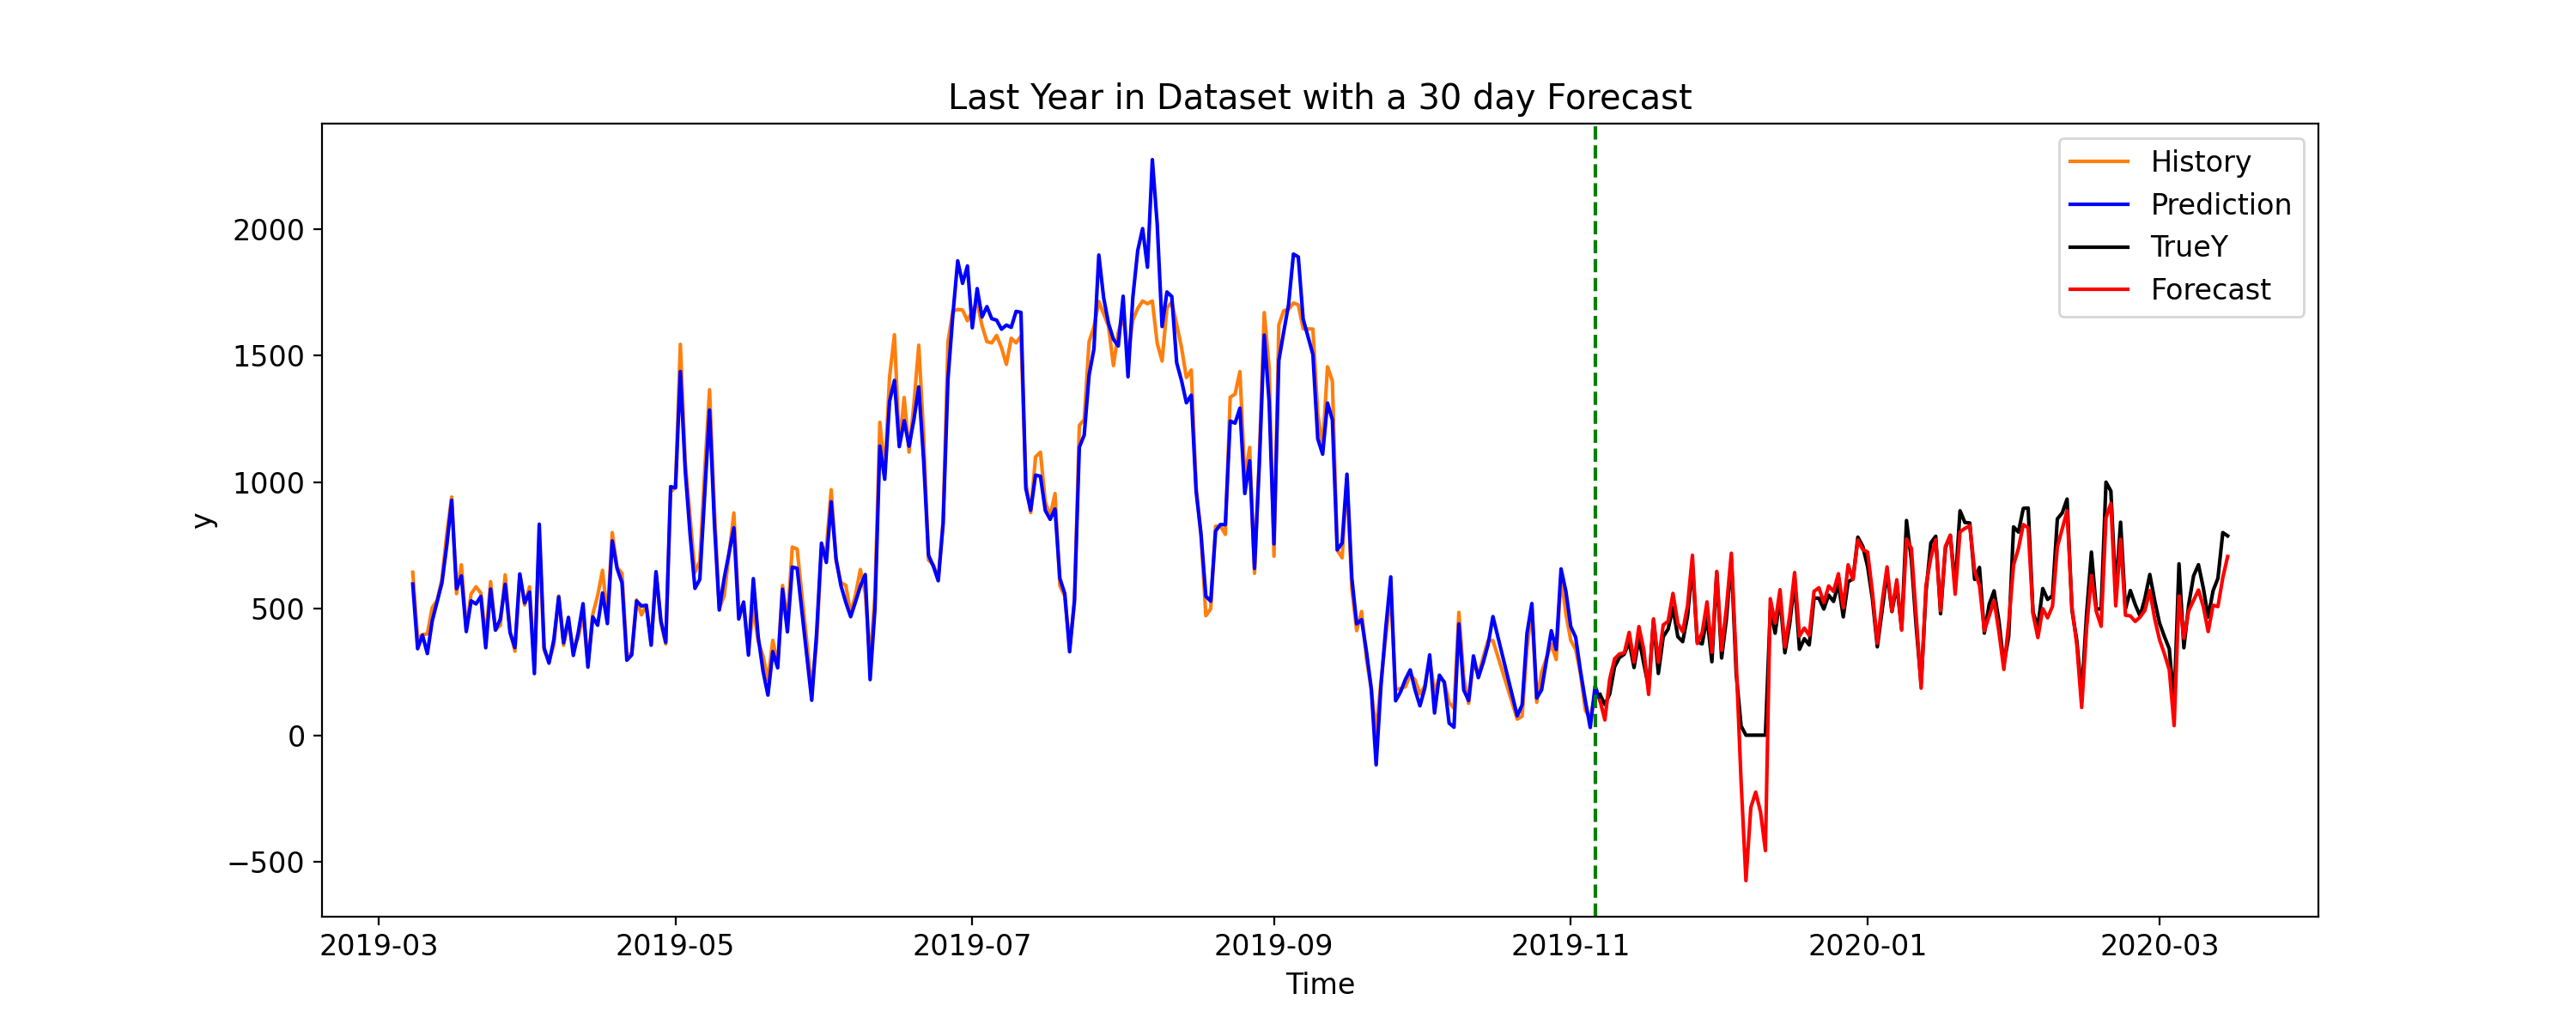

In [428]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')
ax.plot(df.index[-365:-k+1], forecast['yhat'][-365:-k+1], color='b', label='Prediction')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecast['yhat'][-k:], color='red', label='Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast')
plt.legend()